# Overview: Torch OWL (towl) - Introduction

## 1. Preparation

To start the analysis, disable all bridge asynchronicity by running the following:


```
export PT_HPU_ENABLE_EXECUTION_THREAD_NO_WAIT=1
export PT_HPU_EAGER_4_STAGE_PIPELINE_ENABLE=0
export PT_HPU_EAGER_PIPELINE_ENABLE=0
export PT_HPU_DISABLE_ASYNC_COLLECTIVE=1
export PT_HPU_ENABLE_LAZY_EAGER_LAUNCH_EXEC_THREAD=0
export PT_HPU_ENABLE_LAZY_EAGER_EXECUTION_THREAD=0
export PT_HPU_ENABLE_COMPILE_THREAD=0
export PT_HPU_ENABLE_EXECUTION_THREAD=0
export PT_HPU_LAZY_ACC_PAR_MODE=0
export PT_HPU_SYNC_LAUNCH=1
```

Exporting towl data can be enabled with the following:

```
export PT_TOWL_LOG_ENABLE=1
```

By default, the logs are exported only for rank 0:  
`~/.habana_logs/0/towl_log.txt`.

When no multicard setup is used, the logs should be exported to
`~/.habana_logs/towl_log.txt`.

## 2. Installation

### 2.1. Installing towl

Install `towl.db` and `towl.user` packages from the github repository. See README.md for instructions.



### 2.2. Installing JupyterLab

To install JupyterLab, follow the instructions available here: https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html.

Once installed, run the below to start the server:

```
jupyter lab --port 5500
```

The server is running on the remote machine so you cannot access it without running browser remotely through X11 forwarding
or setting up a SSH tunnel for port forwarding.

#### 2.2.1. Setting up SSH Tunnel

To setup SSH tunnel to forward `http://127.0.0.1:5500` from your local machine to `http://127.0.0.1:5500` on the remote machine, perform the following:

**Linux user** - run the below:

```
ssh -L 5500:localhost:5500 your-remote-machine-address
```

**Windows user** - follow the instructions here:

https://blog.mobatek.net/post/ssh-tunnels-and-port-forwarding/

### 2.3. Using Jupyter with Visual Studio Code

The VSCode Pupyter extension is intergrated with Python support. For more details, see https://code.visualstudio.com/docs/datascience/jupyter-notebooks.

## 3. Processing Captured Data

### 3.1. Creating Database Using Command Line

To work with captured data, you need to process it using `towl.db` package. The following command lines creates the `db` directory 
and processes given `towl_log.txt`. The output is stored as database in the `db/mydb` directory:

```
mkdir -p db
python -m towl.db create from-log-file [path to towl_log.txt] -o db/mydb [--overwrite]
```

The optional `--overwrite` flag is useful if you already have the `db/mydb` directory. It will be removed before processing data when flag `--overwrite` is passed.

For example:

```
python -m towl.db create from-log-file ${HABANA_LOGS}/0/towl_log.txt -o db/mydb --overwrite
```

### 3.2. Creating Database from Notebook

You can process logs from the notebook. It is useful to approach smaller log files or to work directly with `${HABANA_LOGS}/0/towl_log.txt` file.

In [1]:
import towl.db as tdb
import os

# tdb.create_from_log_file(
#    os.path.join(os.environ['HABANA_LOGS'], "0", "towl_log.txt"),
#    "tmpfiles/db",
#    overwrite=True,
#    do_nothing_if_exists=False,
# )
tdb.create_from_log_file(
    "data/towl_log.txt.xz",
    "tmpfiles/db",
    overwrite=True,
    do_nothing_if_exists=True,
)

Keyword parameters:
* `overwrite` - Same meaning as for the command line version.
* `do_nothing_if_exists` - Do nothing if the output directory already exists.

## 4. Working with Data

Usefull packages are listed below.

**Note**: The `itables` can be hidden in rows.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Good package for browsing DataFrames
import itables

# Configuring matplotlib output size
plt.rcParams['figure.figsize'] = (12, 5)

To work with data, the import `towl.user` package. In the below example it is imported as `tu`:

In [ ]:
import towl.user as tu

### 4.1. Loading Database

To load database, construct the `Scenario` object passing path to processed database as the only parameter:

In [4]:
scenario = tu.Scenario('tmpfiles/db')

### 4.2. Events and Time Ranges

The database contains events emitted by bridge. Events like *memory allocation*, *memory free*, *recipe launch*, events emitted by python, etc.
We treat them as our abstract notion of time since they are ordered.

In [5]:
print('Scenario global time range:', scenario.global_event_timerange)

Scenario global time range: EventTimeRange(begin=0; end=378258; 378258 events)


The `global_event_timerange` property of the `Scenario` object gives the event timerange representing all captured scenario.

Many `pandas.DataFrame` objects created by `towl.user` will be indexed by event number.

### 4.3. Views

The data is accessed through the `ScenarioView` object, which is data view restricted to given time range.

In [6]:
global_view = scenario.make_view(scenario.global_event_timerange)
# shortcut:
global_view = scenario.make_global_view()

The event time range is represented by `EventTimeRange` object.

For given time range, you can create view using `Scenario.make_view` method.


### 4.4. Getting Memory Usage

For given scenario view, you can query memory usage using `ScenarioView.query_memory_usage` method. It returns dataframe indexed by event number
indicating how much memory is used according to the bridge device memory manager.

* Column `used` indicates how much memory was used.
* Column `persistent` indicates how much memory was occupied by persistent tensors.
* Column `workspace` indicates size of a workspace buffer.
* Columns `used_str`, `persistent_str`, `workspace_str` are human-friendly formatted data.
* Column `tag` gives information about place in bridge when memory stats were exported:
    * `Post-Workspace` - after assuring that the workspace buffer is enough to launch the recipe.
    * `Post-Tensors` - after allocating tensors required to launch the recipe.
    * `OOM-Tensor` - after Device Out Of Memory (DOOM) encountered during tensor allocation.
    * `OOM-Workspace` - after DOOM encountered during the workspace buffer adjustment.
    * `Post-Defrag` - after defragmenter. 
    * `Post-Recipe-Decrease-Workspace` - after the workspace buffer shrinkage.
    * Grep bridge source code by given tag to get better understanding about particular events.

This kind of event is modeled after similar information from bridge log (`pytorch_log.txt`).

In [8]:
global_memory_usage_df = global_view.query_memory_usage()
print(type(global_memory_usage_df))


<class 'pandas.core.frame.DataFrame'>


In [11]:
itables.show(global_memory_usage_df)

**Note:** The dataframe is indexed by the event number (`event_ident`). Normally dataframes are indexed by the row number.
When accessing dataframe with `loc` accessor, use index. To use row number, utilize `.iloc`.

In [12]:
print('Index[0] =', global_memory_usage_df.index[0])
print('*** Access by index\n', global_memory_usage_df.loc[522])
print('*** Access by row number\n', global_memory_usage_df.iloc[0])

Index[0] = 522
*** Access by index
 used                 27113152640
workspace                4194304
persistent           27108958336
tag               Post-Workspace
workspace_str          4.000 MiB
persistent_str        25.247 GiB
used_str              25.251 GiB
Name: 522, dtype: object
*** Access by row number
 used                 27113152640
workspace                4194304
persistent           27108958336
tag               Post-Workspace
workspace_str          4.000 MiB
persistent_str        25.247 GiB
used_str              25.251 GiB
Name: 522, dtype: object


### 4.5. Plotting Memory Usage

Towl contains ready-to-use matplotlib routines to draw data. They are accessible through `tu.plots` submodule:

<Figure size 1200x500 with 0 Axes>

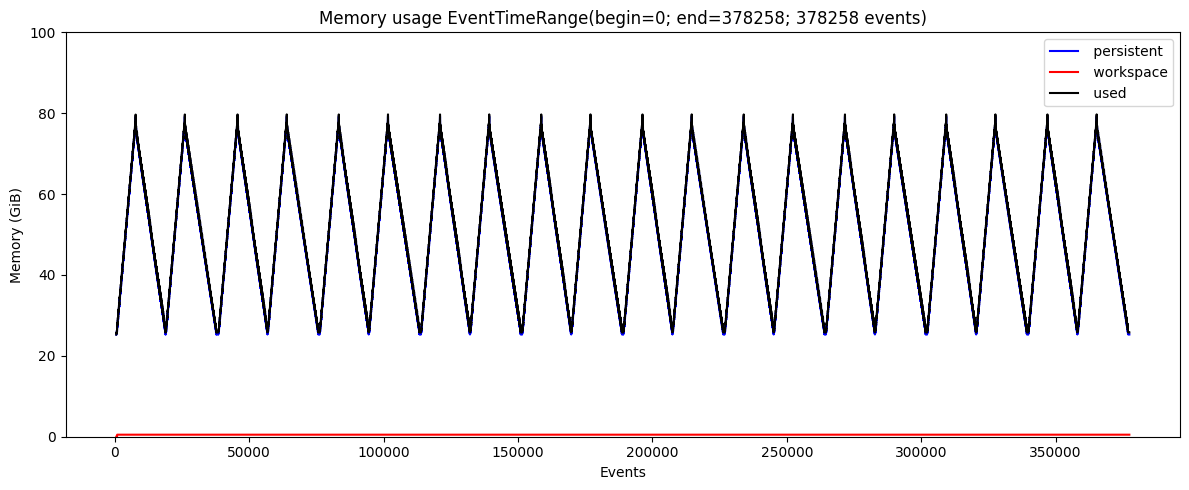

In [13]:
tu.plots.plot_memory_usage(global_view)

A plot of memory usage was received from the given view. 

**Note:** The `x` axis is represented by the event number.

### 4.6. Utility for Finding Hills

The `tu.lib` submodule contains various utilities useful for processing data. One of them provides a possibility for finding hills on given data serie:

In [15]:
global_hills = tu.lib.find_hills(global_memory_usage_df['used'], 10*1024**3)
print('Found', len(global_hills), 'hills')
print('Hill 0 =', global_hills[0])
print('Hill 1 =', global_hills[1])

Found 20 hills
Hill 0 = EventTimeRange(begin=522; end=18828; 18306 events)
Hill 1 = EventTimeRange(begin=18837; end=37779; 18942 events)


The code above enables finding all hills (where value goes up and then down) where threshold for "detection" is 10GiB.
The below is a selected hill on the global memory plot.

<Figure size 1200x500 with 0 Axes>

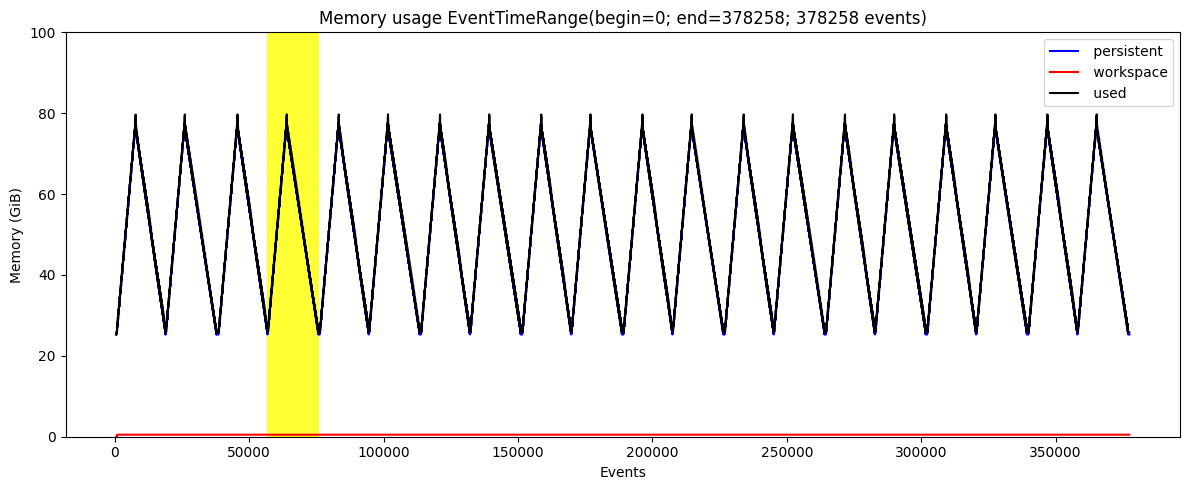

In [13]:
with tu.plots.MatplotLib():
    tu.plots.plot_memory_usage(global_view)
    tu.plots.plot_shadow(global_hills[3])

You can add time ranges as well. Adding two ranges creates a range covering time period containing two source ranges:

In [14]:
print(global_hills[0])
print(global_hills[3])
print(global_hills[0] + global_hills[3])

EventTimeRange(begin=522; end=18828; 18306 events)
EventTimeRange(begin=56763; end=76113; 19350 events)
EventTimeRange(begin=522; end=76113; 75591 events)


The formula is simple - for two time ranges $(a, b)$ and $(a', b')$, where $a, a'$ stands for range beings, and $b, b'$ for range endings, we have:
$$ (a, b) + (a', b') = (\min(a, a'), \max(b, b'))$$


The below is a view for plotted previously hill:

In [16]:
hill_view = scenario.make_view(global_hills[3])

The below is a view for plotted memory usage:

<Figure size 1200x500 with 0 Axes>

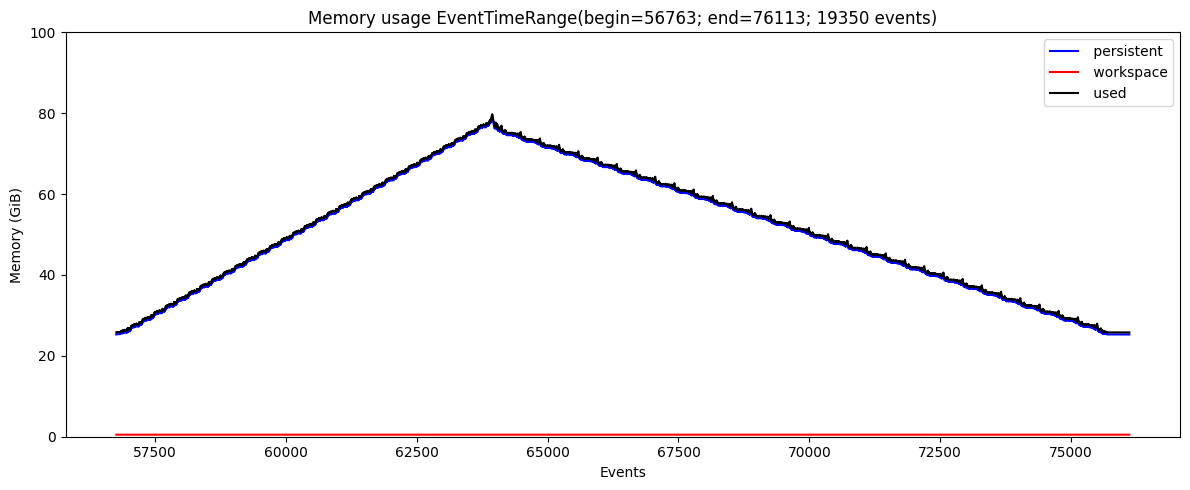

In [17]:
tu.plots.plot_memory_usage(hill_view)

Only selected lines can also be plotted. For example, to print only persistent, run:

<Figure size 1200x500 with 0 Axes>

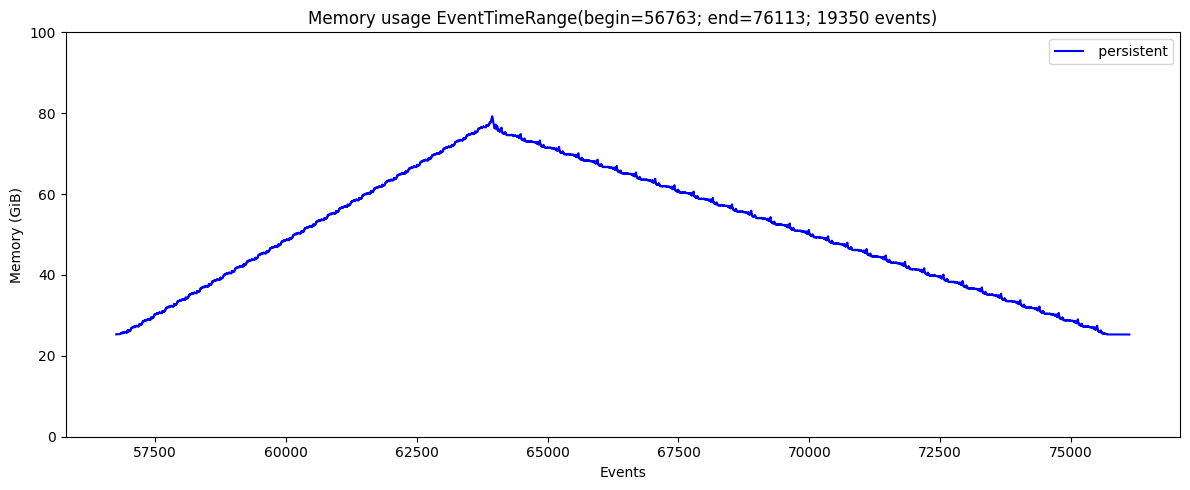

In [18]:
tu.plots.plot_memory_usage(hill_view, workspace=False, used=False)

**Note:** The `x` axis is indexed by the event number.

### 4.7 Using PyTorch CUDA Memory Visualizer

Data can be exported and converted to HTML page for buffer lifetime visualization using PyTorch CUDA Memory Visualizer:

In [19]:
tu.lib.dump_cudamemviz(hill_view, 'tmpfiles/hill.pickle', 'tmpfiles/hill.html')

> /home/pwieczorek/VENV/bin/python -m torch.cuda._memory_viz trace_plot -o 'tmpfiles/hill.html' 'tmpfiles/hill.pickle'


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'torch.cuda._memory_viz' found in sys.modules after import of package 'torch.cuda', but prior to execution of 'torch.cuda._memory_viz'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


The `dump_cudamemviz` routine converts data to the required format (stored here as `/tmp/hill.pickle` file) and then converts it to HTML page `hill.html` using PyTorch.

**Note:** The chromium-based browser is required to open the file.

The same can be done for any other view:

In [20]:
tu.lib.dump_cudamemviz(global_view, 'tmpfiles/all.pickle', 'tmpfiles/all.html')

> /home/pwieczorek/VENV/bin/python -m torch.cuda._memory_viz trace_plot -o 'tmpfiles/all.html' 'tmpfiles/all.pickle'


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'torch.cuda._memory_viz' found in sys.modules after import of package 'torch.cuda', but prior to execution of 'torch.cuda._memory_viz'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


**Note: You can try to collect Python stack traces for allocation points using topology instrumentation. See section 5.2 for further informations.**

#### 4.7.1. Pro Tip: Accessing Remote Files

To access files remotely, you can start HTTP server by running the below:

```
python -m http.server --bind 127.0.0.1 5501
```

It creates HTTP server that allows to access the files in the current directory. You can setup SSH tunnel from your local machine to access this server.

### 4.9. Getting Memory Allocations/Deallocations

You can fetch all memory allocations/deallocations inside an associated time range for the given view.

* *memory allocations* - Approached as `device_memory::malloc` in our bridge.
* *memory deallocations* - Approached as `device_memory::free` in our bridge.

**Note:** *meterialization* operation related to the `device_memory::alloc` routine will most likely be added in the future.

In [19]:
buffers_allocs = hill_view.query_buffers_allocs()
itables.show(buffers_allocs)

/home/pwieczorek/VENV/lib/python3.10/site-packages/itables/datatables_format.py:93: UserWarning: The columns ['addr'] contains integers that are too large for Javascript.
They have been converted to str. See https://github.com/mwouts/itables/issues/172.
To silence this warning, please run:
    import itables.options as opt
    opt.warn_on_int_to_str_conversion = False
  warnings.warn(


**Note:** The dataframe is indexed by the event number.

Columns:
* `is_allocation` - indicates if given operation is malloc or free.
* `buffer_ident` - buffer private identifier.
* `addr` - buffer address.
* `size` - size of buffer.
* `unknown` - to be described.
* `addr_str` - human-friendly string with address.
* `size_str` - human-friendly string with size.
* `change` - size multiplied by 1 for alloc and -1 for free.
* `change_str` - human-friendly string for change.
* `event_malloc` - event number when buffer is allocated.
* `event_free` - event number when buffer is deallocated.
* `event_first_launch` - event number when any recipe get this buffer, for the first time in whole scenario.
* `event_last_launch` - event number when any recipe get this buffer, for the last recorded time in whole scenario.

**Note:** The tool does not track operations like memory copying and broadcast operations (like allgather). This functionality will be added in the future.

### 4.10. Recipe Launches

In [20]:
launches = hill_view.query_recipe_launches()
itables.show(launches)

**Note**: The recipe launch event is emitter by the bridge after device memory allocation. In case of Device Out Of Memory (DOOM), you will not have recipe that caused DOOM. This functionality will be added in the future.

Columns
* `launch_ident` - launch private identifier.
* `handle` - synRecipeHandle
* `handle_str` - human-friendly `handle`.
* `workspace` - size of required workspace buffer size.
* `workspace_str` - human-friendly `workspace`.
* `event_launch` - event number when launch happened.
* `event_finished` - event number when computaiton was finished.
* `recipe_name` - recipe name assigned by bridge.

### 4.11. Recipe Detailed Information

Both `Scenario` and `ScenarioView` provide accessors to get more information about particular launch.
* `.query_recipe_by_launch_ident(launch_ident)` - query using launch private identifier.
* `.query_recipe_by_event_ident(event_ident)` - query using event number where launch occured.


In [23]:
recipe_launch = scenario.query_recipe_launch_by_launch_ident(11588)
print(recipe_launch)

RecipeLaunch(event_ident=75836 launch_ident=11588 handle=0x560a86d26960 workspace=384 B event={launch=75836 finished=75838})


In [24]:
recipe_launch.event_lifetime

EventTimeRange(begin=75836; end=75839; 3 events)

In [25]:
recipe_launch.query_recipe_launch_buffers()

,buffer,offset,synapse_name,bufname
index,,,,
0,11522,0,tensor_0_/placeholder/0,BUF_11522
1,11519,0,tensor_1_/placeholder/0,BUF_11519
2,11515,0,tensor_2_/placeholder/0,BUF_11515
3,11512,0,tensor_3_/placeholder/0,BUF_11512
4,11469,0,tensor_4_/placeholder/0,BUF_11469
...,...,...,...,...
253,15187,0,tensor_405_255,BUF_15187
254,15188,0,tensor_406_256,BUF_15188
255,15189,0,tensor_407_257,BUF_15189


## 5. Instrumentation

### 5.1. Setup


Install the `towl-instrument` package from the github repository. See README.md for instructions.

This package must be installed on the machine/environment where you run a topology. It adds functionalities
allowing to provide extra data from the Python script to the tool. We keep this functionality as yet additional package to not
impose any unnecessary Python dependencies inside Kubernetes environments.

In the below example, the installed package is imported under `ti` name:

In [ ]:
import towl.instrument as ti

### 5.2. Getting Python Stacktraces for Allocation Points

You can try to catch Python stacktrace for places where tensors are allocated. It is extremely useful when used together
with *PyTorch CUDA Memory Visualizer*.

The method iterates over torch modules and wraps them by our function that records allocation points. 
In Lazy mode, tensors could not have storages at allocation points. To mitigate this issue, background thread is started.
It checks if the observed tensors have already allocated storage and reports it to towl every 1/10 second.

```
ti.MemoryInterceptor.enable()
```

**Note**: Sometimes interceptor cannot be installed too soon and this code cannot be added early in the main script. It is enough to add it before training/inference loop.

You can use the `MemoryInterceptor.install_wrappers_on` method to install wrappers on given module. It can be useful when topology uses a framework like Megatron or Transformers.

In [ ]:
# ti.MemoryInterceptor.install_wrappers_on(mymodule, recursive=False)

Keyword parameters:
* mandatory `recursive` - instructs towl if given module should be scanned recursively to automaticly install wrappers on imported modules.

When MemoryInterceptor is enabled, it automatically installs wrappers on the `torch` module only.